# 1. Modules

## 1.1. Load basics

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [3]:
import sys
sys.path.append('../../..')

## 1.2. Load library modules

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt


from IPython.display import display, clear_output

from magrec import __datapath__
from magrec.prop.Propagator import CurrentPropagator2d, AxisProjectionPropagator, HeightContinuationPadder, ZeroPadder
from magrec.nn.arch import GeneratorCNN
from magrec.misc.plot import plot_n_components

# 2. Data

## 2.1. Load Data¶

We'll be working with the Nb wire dataset, which has three components of the magnetic field known, and known simulated NV orientation angle. There's also a plausible reconstruction available in the notebook `Test_Magnetic_Field_Recon.ipynb`. The goal of this notebook is to achieve a similar or better performance by optimization.

First we load the data and look at what we want to reconstruct the current from:

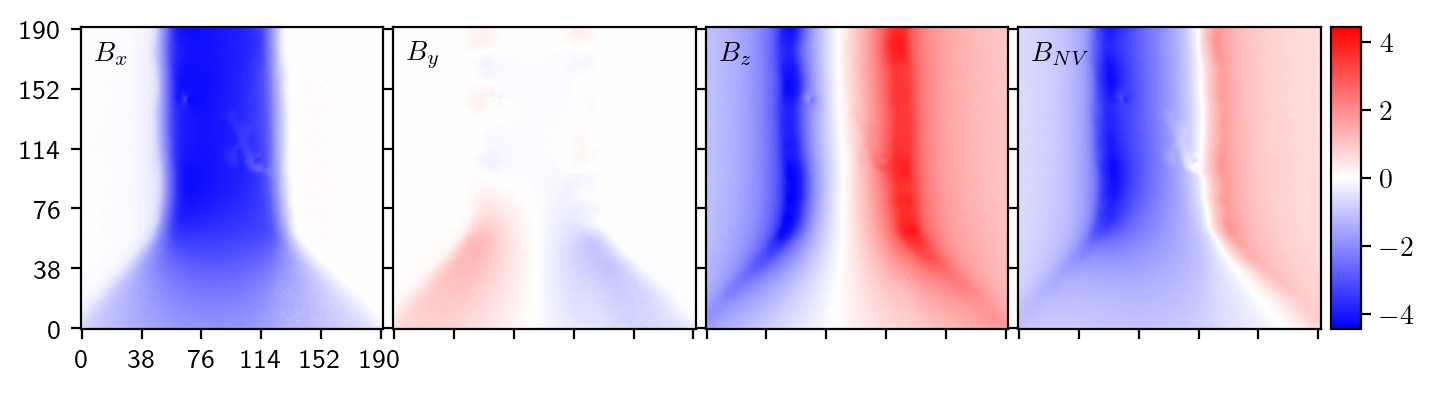

In [59]:
Bx = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bx.txt")
By = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "By.txt")
Bz = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bz.txt")

B = np.empty(shape=(4, 201, 201))

setTheta = np.deg2rad(54.7)
setPhi = np.deg2rad(45)

unv = [np.sin(setTheta) * np.cos(setPhi),
       np.sin(setTheta) * np.sin(setPhi),
       np.cos(setTheta)]

B[0, :, :] = np.flipud(Bx)
B[1, :, :] = np.flipud(By)
B[2, :, :] = np.flipud(Bz)
B[3, :, :] = np.flipud(Bx*unv[0] + By*unv[1] + Bz*unv[2])


# Trim B to a size of such that is divisable by 2^4 = 16 (for the convolutional layers)
# The largest number divisible by 16 that is smaller than 201 is 192
W = 192
H = 192            
# Select this region from the center of the data tensor
trim = 8
B = B[:, trim:trim+W, trim:trim+H]

plot_n_components(B, labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

## 2.2. Define parameters

In [6]:
dx=0.408  # in μm
dy=0.408

height = 0.015          # μm
layer_thickness = 0.030 # μm

theta = 54.7            # degrees
phi = 30.0              # degrees

# 3. Current reconstruction

## 3.1. Define J → B transformation

In [115]:

shape = (1, 2, W, H)
pad1 = HeightContinuationPadder(shape=shape)
pad2 = ZeroPadder(shape=pad1.expanded_shape)
propagator = CurrentPropagator2d(source_shape=pad2.expanded_shape,
                                 dx=dx, dy=dy, height=height, layer_thickness=layer_thickness,)
proj = AxisProjectionPropagator(theta=theta, phi=phi)


def compute_B(J: torch.tensor):
    J = pad1.pad(J)
    J = pad2.pad(J)
    B = propagator(J)
    B = pad2.unpad(B)
    B = pad1.unpad(B)
    B_NV = proj.project(B)
    # That's a more general stacking to allow for batch dimension
    B = torch.stack([B[..., -3, :, :], 
                     B[..., -2, :, :], 
                     B[..., -1, :, :], 
                     B_NV[...]], 
                     dim=-3)
    return B


## 3.3. Define net, optimizer, loss function and training loop

In this case, we will be using a neural network to take B, convert it to J through it's net parameters, and calculate the error using `compute_B_NV` above.

In [116]:
# Here we define the loss function and the optimization algorithm
def train_net(net: torch.nn.Module, B, n_iter=1000, plot_interval=100, lr=1.):
    """Run the optimization loop.
    
    Parameters
    ----------
    B : np.ndarray or torch.tensor
        The measured magnetic field to match with a reconstructed current density

    n_iter : int, optional
        Number of iterations, by default 1000

    plot_interval : int, optional
        Number of iterations between each plot, by default 100
    
    Returns
    -------
    J : torch.tensor
        The reconstructed current density
    """ 
    # Define the loss function and the optimizer
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam

    # Add the optimizer to the parameters
    optimizer = optimizer(net.parameters(), lr=lr)

    # Convert B to a torch tensor of float32
    B = torch.from_numpy(B).float()

    # Extract the B_NV component from the measured B
    B_NV = B[3, ...]
    
    # Add a batch dimension, since we are optimizing only on one sample
    B_NV = B_NV[None, None, ...]

    # Initialize a list to track loss and update it on each iteration
    track_loss = []

    # Prepare a figure to plot the loss
    fig_loss = plt.figure('Loss')
    fig_loss.suptitle('Loss as a function of iteration')
    fig_loss.supxlabel('Iteration')
    fig_loss.supylabel('Loss')
    
    # Make an axis to plot the loss
    ax_loss = fig_loss.add_subplot(111)

    def show_progress(B_pred, J_rec):
        print(f"Loss at iteration {i}: {loss.item()}")
        fig1 = plot_n_components(J_rec.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")
        fig2 = plot_n_components(B_pred.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

        # Plot the loss as a function of iteration
        ax_loss.clear()
        ax_loss.plot(track_loss)
        
        # Make y axis log scale
        ax_loss.set_yscale('log')

        # Display the output in the notebook and clear the output
        display(fig1)
        display(fig2)
        display(fig_loss)
        clear_output(wait=True)


    def print_changed_lr(lr):
        """Print once if the learning rate changed"""
        if print_changed_lr.current_lr != lr:
            print(f"Learning rate changed to {lr}")
        print_changed_lr.current_lr = lr

    print_changed_lr.current_lr = 1

    # Make a for loop for training to optimize the current J
    for i in range(n_iter):
        # Compute the predicted B_NV
        J_pred = net(B_NV)

        # Compute the predicted B that corresponds to the output current
        B_pred = compute_B(J_pred)

        # Extract the B_NV component
        B_pred_NV = B_pred[:, 3, ...]

        # Add a dimension that corresponds to the component
        B_pred_NV = B_pred_NV[:, None, ...]
        
        # Compute the loss
        loss = loss_fn(B_pred_NV, B_NV)
        # Add the loss to the list
        track_loss.append(loss.item())
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss
        if i % plot_interval == 0:
            show_progress(B_pred, J_pred)

        # If the loss is smaller then this value, change the learning rate
        if loss.item() >= 1e-1:
            print_changed_lr(1.)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        elif loss.item() < 1e-1:
            print_changed_lr(1e-1)
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-1
        elif loss.item() < 1e-3:
            print_changed_lr(1e-3)
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-3
        
        # If the loss is small enough, stop the optimization
        if loss.item() < 1e-6:
            print('Stopping optimization, converged to a loss of < 1e-10')
            show_progress()
            break

    pass

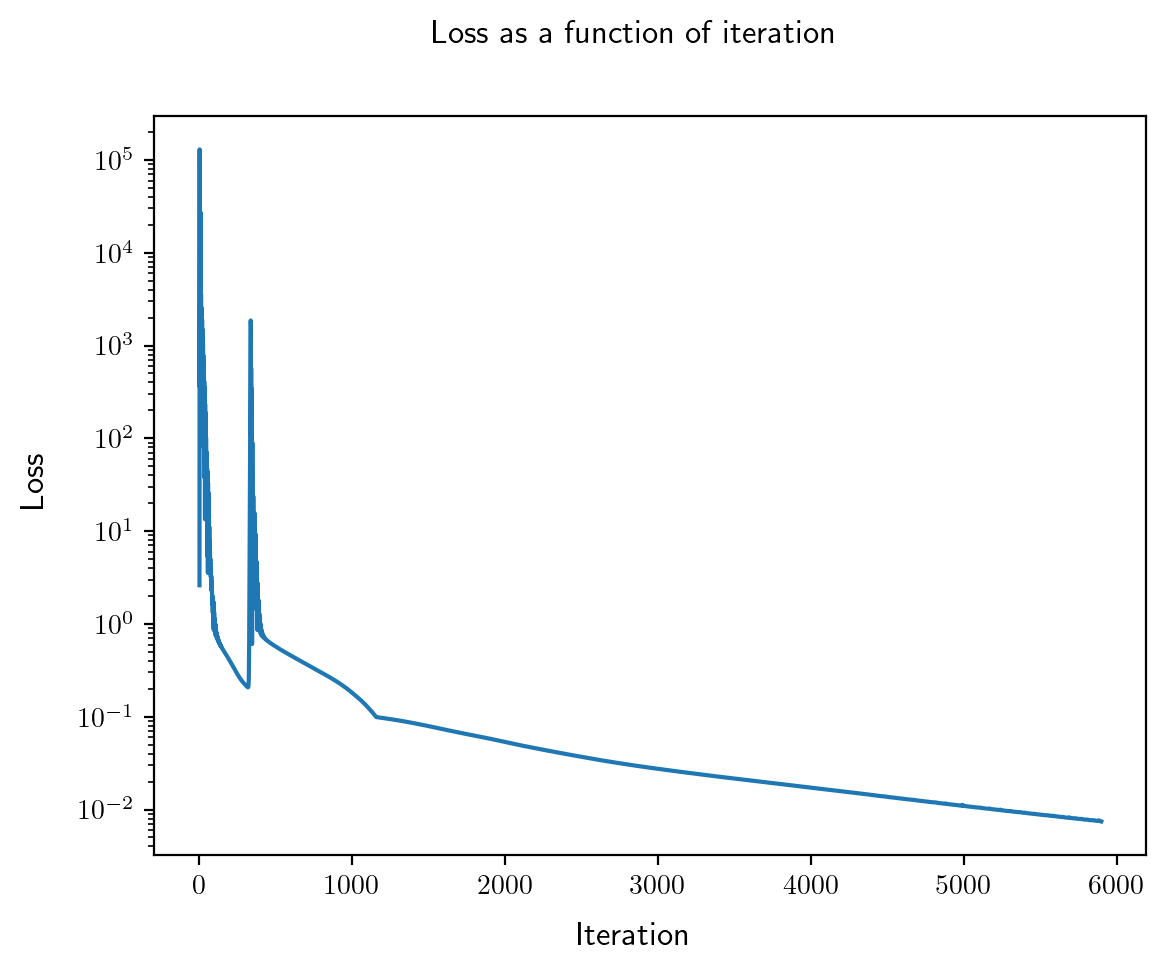

In [117]:
# Define the network to be trained
# Channel in is 1 for the case when we only train on the B_NV component
net_new = GeneratorCNN(n_channels_in=1, n_channels_out=2)
    
# Train the network
train_net(net_new, B, 6000, 100)

Above we see that the net produces artifacts and also has problems with the components of the magnetic field.

I see two possible sources of the problem that can be tackled:

1. In `arch.py:80-83`, `torch.cat` acts on `dim=1`, which is the dimension of the component 
2. `torch.cat` itself acting on the results of the `conv` layers and `trans` (transpose convolutional layers) is questionable: why would components of the magnetic field have skip connections to the redeconvolution? We need to test another architecture for that.
3. Make a better padding to pad J tensor as needed. 

In [ ]:
pad_repl = torch.nn.ReplicationPad2d((W, W, H, H))
pad_zero = torch.nn.ZeroPad2d((W, W, H, H))

def compute_B(J: torch.tensor):
    J = pad_repl(J)
    J = pad_zero(J)
    B = propagator(J)
    B = B[..., 2*W:-2*W, 2*H:-2*H]
    B_NV = proj.project(B)
    # That's a more general stacking to allow for batch dimension
    B = torch.stack([B[..., -3, :, :], 
                     B[..., -2, :, :], 
                     B[..., -1, :, :], 
                  B_NV[..., 0, :, :]], 
                     dim=-3)
    return B

In [96]:
def test_net(net: torch.nn.Module, B: torch.Tensor):
    net.eval()

    # Convert B to a torch tensor of float32
    B = torch.from_numpy(B).float()

    # Extract the B_NV component from the measured B
    B_NV = B[3, ...]
    
    # Add a batch dimension, since we are optimizing only on one sample
    B_NV = B_NV[None, None, ...]

    J_pred = net(B_NV)
    B_pred = compute_B(J_pred)

    fig1 = plot_n_components(J_pred.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")
    fig2 = plot_n_components(B_pred.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

    display(fig1, fig2)
    pass

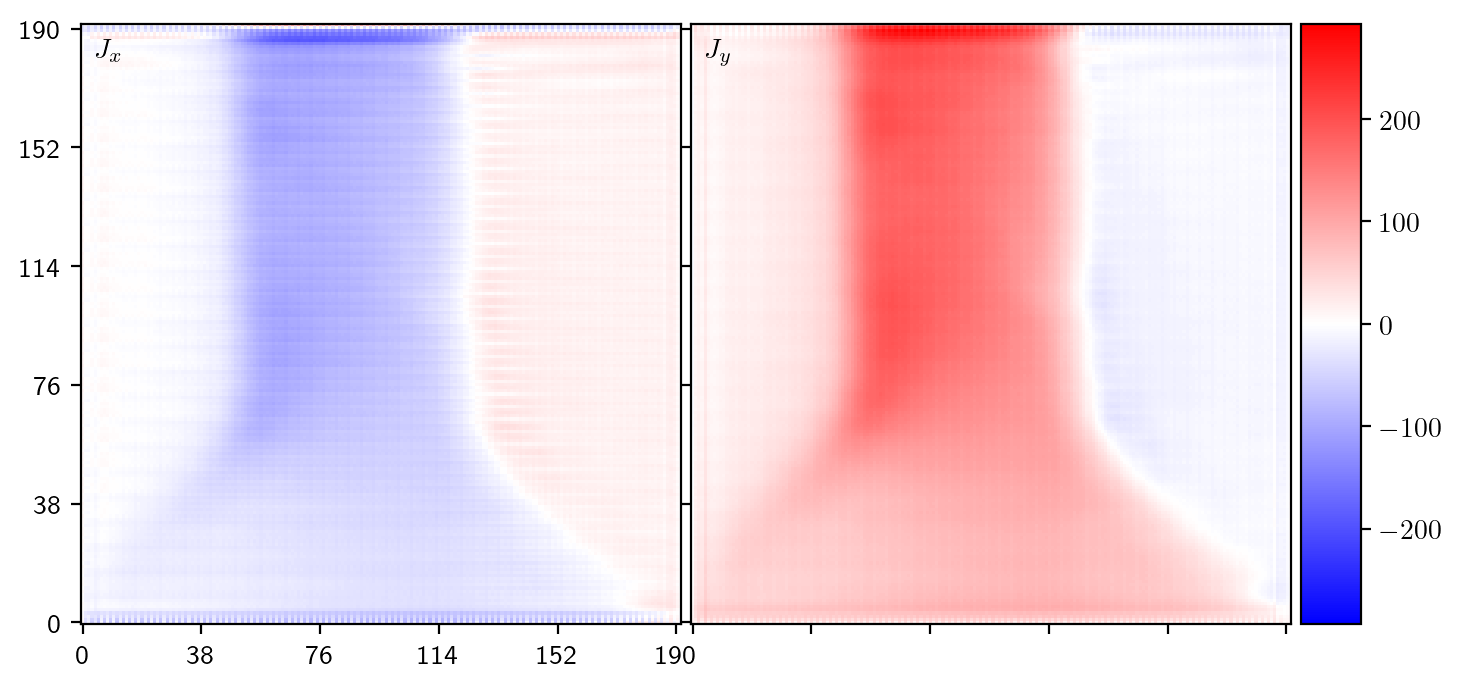

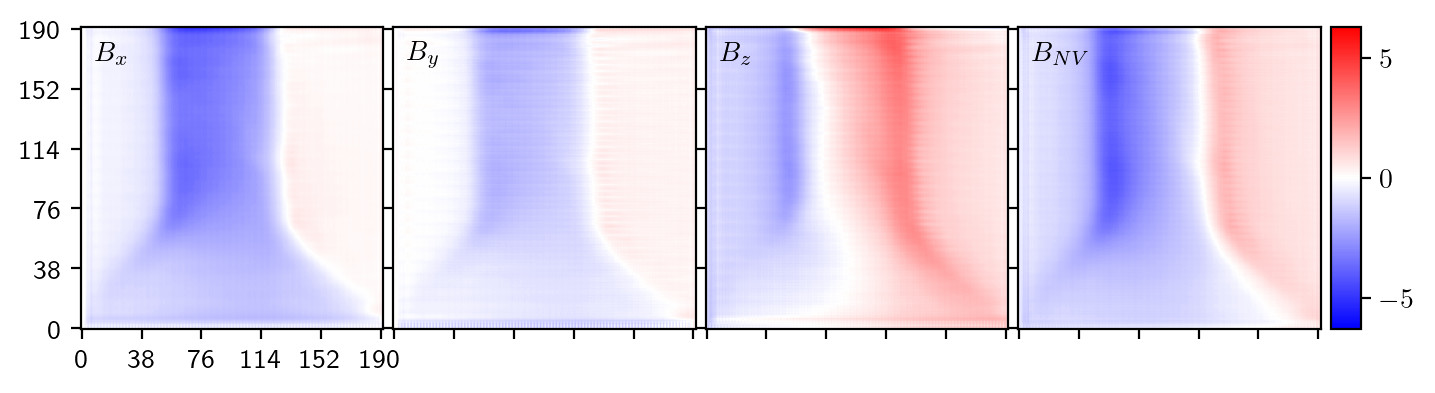

In [97]:
test_net(net, B)